# Data

* 데이터: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset
* 필사 출처: https://www.kaggle.com/code/bahadoreizadkhah/face-mask-detection-with-pytorch-cnn

* cloth --> Cloth face mask images
* n95 --> N95 face mask images
* n95v --> N95 with Valve face mask images
* nfm --> No Face Mask images
* srg --> Surgical face mask images

## Dataset

### Importing Libraries

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from PIL import Image
from datetime import datetime
from pytz import timezone


import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from torch.nn import Conv2d, BatchNorm2d, ReLU, Dropout2d, MaxPool2d, Sequential, Module, CrossEntropyLoss
from tqdm.notebook import tqdm
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

In [2]:
# 파일 압축 해제
!unzip mask.zip

Archive:  mask.zip
  inflating: Dataset/test/cloth/0.jpg  
  inflating: Dataset/test/cloth/1.jpg  
  inflating: Dataset/test/cloth/2.jpg  
  inflating: Dataset/test/cloth/3.jpg  
  inflating: Dataset/test/cloth/396.jpg  
  inflating: Dataset/test/cloth/397.jpg  
  inflating: Dataset/test/cloth/398.jpg  
  inflating: Dataset/test/cloth/399.jpg  
  inflating: Dataset/test/cloth/4.jpg  
  inflating: Dataset/test/cloth/400.jpg  
  inflating: Dataset/test/cloth/401.jpg  
  inflating: Dataset/test/cloth/402.jpg  
  inflating: Dataset/test/cloth/403.jpg  
  inflating: Dataset/test/cloth/404.jpg  
  inflating: Dataset/test/cloth/405.jpg  
  inflating: Dataset/test/cloth/406.jpg  
  inflating: Dataset/test/cloth/407.jpg  
  inflating: Dataset/test/cloth/408.jpg  
  inflating: Dataset/test/cloth/409.jpg  
  inflating: Dataset/test/cloth/410.jpg  
  inflating: Dataset/test/cloth/411.jpg  
  inflating: Dataset/test/cloth/412.jpg  
  inflating: Dataset/test/cloth/413.jpg  
  inflating: Dataset/test

In [24]:
# train directory
directory = "Dataset/train"

# test directory
tst_dir = "Dataset/test"

gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
torch.manual_seed(0)
sns.set_style("darkgrid")
workers = 2

## Image Processing

### Resizing and Changing images format into jpg

In [14]:
counter = 0

for image in glob.glob('Source path/*.*'):
    img = Image.open(image)
    rgb_img = img.convert('RGB')
    new_image = rgb_img.resize((300, 300))
    new_image.save('Destination Path/' + str(counter) + '.jpg')
    counter += 1

print('All done!')

All done!


### Image transformation and Label definition

In [15]:
image_transforms = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [17]:
dataset = ImageFolder(
    root=directory,
    transform=image_transforms
)
idx2class = {
    v: k for k, v in dataset.class_to_idx.items()
    }

print('Dataset has', len(dataset), 'elements with the following classes:\n', dataset.class_to_idx)

Dataset has 1956 elements with the following classes:
 {'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [18]:
count_dict = {
    k: 0 for k, v in dataset.class_to_idx.items()
    }
    
for element in dataset:
    y_lbl = element[1]
    y_lbl = idx2class[y_lbl]
    count_dict[y_lbl] += 1

print("Distribution of classes: \n", count_dict)

Distribution of classes: 
 {'cloth': 396, 'n95': 354, 'n95v': 390, 'nfm': 474, 'srg': 342}


In [19]:
y_label_plt = []
count_of_y_label = []
for key, values in count_dict.items():
    y_label_plt.append(key)
    count_of_y_label.append(values)

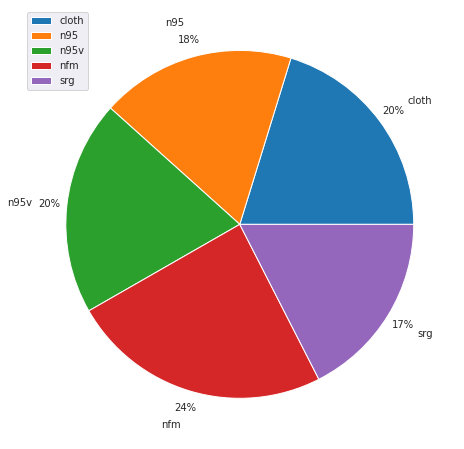

In [20]:
plt.pie(count_of_y_label, labels=y_label_plt, autopct="%1.0f%%",
       pctdistance=1.1, labeldistance=1.2)
plt.gcf().set_size_inches(8,8)
plt.legend()
plt.show()

### Train Test Split

In [22]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [25]:
batch_size = 16
train_loader = DataLoader(dataset=dataset, batch_size = batch_size,
                          sampler=train_sampler, num_workers=workers)
val_loader = DataLoader(dataset=dataset, batch_size=1,
                        sampler=val_sampler, num_workers=workers)

In [26]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k: 0 for k, v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _, label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _, label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Validation Set')

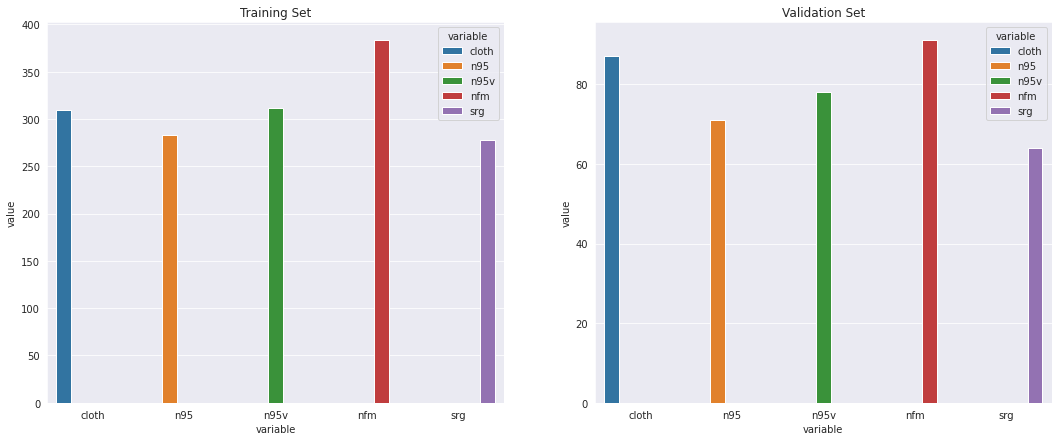

In [27]:
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data=pd.DataFrame.from_dict([dict_obj]).melt()
    , x="variable", y="value", hue="variable", **kwargs).set_title(plot_title)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

plot_from_dict(get_class_distribution_loaders(train_loader, dataset), plot_title="Training Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, dataset), plot_title="Validation Set", ax=axes[1])

In [29]:
single_batch = next(iter(train_loader))
single_image = single_batch[0][0]
print("Single batch: ", single_batch[0].shape)
print("Single image shape: ", single_image.shape)

Single batch:  torch.Size([16, 3, 300, 300])
Single image shape:  torch.Size([3, 300, 300])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output label tensors:  tensor([3, 4, 4, 3, 3, 3, 3, 3, 2, 2, 4, 3, 0, 3, 2, 2])

Output label tensor shape:  torch.Size([16])


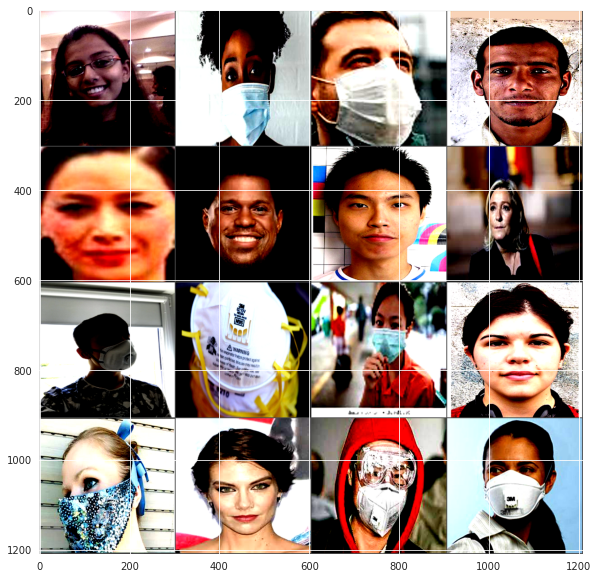

In [30]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(single_batch_grid.permute(1, 2, 0) + 0.3)
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

## Convolutional Neural Networks (CNN)

### Model Hyper-Parameters

In [38]:
learning_rate = 0.00146
epochs = 15
wd = 1e-6
dropout = 0.1

### Building the Model

In [33]:
class CNN_Classifier(Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.block1 = self.conv_block(input=3, output=512, dropout=dropout, kernel_size=5, stride_factor=2)
        self.block2 = self.conv_block(input=512, output=256, dropout=dropout, kernel_size=3, stride_factor=2)
        self.block3 = self.conv_block(input=256, output=128, dropout=dropout, kernel_size=3, stride_factor=2)
        self.block4 = self.conv_block(input=128, output=64, dropout=dropout, kernel_size=3, stride_factor=2)
        
        # Fully Connected Network
        
        self.lastcnn = Conv2d(in_channels=64, out_channels=5, kernel_size=4, stride=2)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    
    def conv_block(self, input, output, dropout, kernel_size, stride_factor):
        cnn_model_block = Sequential(
            Conv2d(in_channels=input, out_channels=output, kernel_size=kernel_size, stride=stride_factor),
            BatchNorm2d(num_features=output),
            ReLU(),
            Dropout2d(p=dropout)
        )
        return cnn_model_block

### Model Summary

In [34]:
print(CNN_Classifier())

CNN_Classifier(
  (block1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 5, kernel_size=(4, 4

### Training the Model

In [35]:
def measure_acc(y_predict, y_test):
    y_pred_softmax = torch.log_softmax(y_predict, dim=1)
    _, y_pred = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred == y_test).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    accuracy = torch.round(accuracy * 100)
    return accuracy

In [39]:
accuracy_stats = {
    'train': [],
    "validation": []
}

loss_stats = {
    'train': [],
    "validation": []
}

cnn_model = CNN_Classifier()
cnn_model.to(gpu)
loss = CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=wd)

print("Training begins at:", datetime.now(timezone('EST')).strftime("%H:%M"))
for epoch in tqdm(range(1, epochs + 1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    cnn_model.train()

    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(gpu), y_train.to(gpu)

        optimizer.zero_grad()
        y_train_pred = cnn_model(X_train).squeeze()

        train_loss = loss(y_train_pred, y_train)
        train_acc = measure_acc(y_train_pred, y_train)

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0
        cnn_model.eval()

        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(gpu), y_val.to(gpu)
            y_val_pred = cnn_model(X_val).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)

            val_loss = loss(y_val_pred, y_val)
            val_acc = measure_acc(y_val_pred, y_val)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['validation'].append(val_epoch_loss / len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
    accuracy_stats['validation'].append(val_epoch_acc / len(val_loader))
    
    print(
        f'Epoch {epoch + 0:02} / {epochs}: | Train Loss: {train_epoch_loss / len(train_loader):.5f} '
        f'| Validation Loss: {val_epoch_loss / len(val_loader):.5f} '
        f'| Train Accuracy: {train_epoch_acc / len(train_loader):.3f}'
        f'| Validation Accuracy: {val_epoch_acc / len(val_loader):.3f}')
    
print("Training ends at:", datetime.now(timezone('EST')).strftime("%H:%M"))

Training begins at: 09:41


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01 / 15: | Train Loss: 1.27651 | Validation Loss: 1.32181 | Train Accuracy: 48.347| Validation Accuracy: 46.000
Epoch 02 / 15: | Train Loss: 0.97409 | Validation Loss: 1.08000 | Train Accuracy: 62.122| Validation Accuracy: 38.000
Epoch 03 / 15: | Train Loss: 0.87390 | Validation Loss: 0.85070 | Train Accuracy: 66.520| Validation Accuracy: 69.000
Epoch 04 / 15: | Train Loss: 0.79683 | Validation Loss: 0.54405 | Train Accuracy: 69.582| Validation Accuracy: 85.000
Epoch 05 / 15: | Train Loss: 0.71793 | Validation Loss: 0.34138 | Train Accuracy: 72.673| Validation Accuracy: 85.000
Epoch 06 / 15: | Train Loss: 0.64377 | Validation Loss: 0.58015 | Train Accuracy: 75.980| Validation Accuracy: 69.000
Epoch 07 / 15: | Train Loss: 0.57048 | Validation Loss: 0.34650 | Train Accuracy: 78.469| Validation Accuracy: 92.000
Epoch 08 / 15: | Train Loss: 0.48374 | Validation Loss: 0.42534 | Train Accuracy: 82.837| Validation Accuracy: 85.000
Epoch 09 / 15: | Train Loss: 0.39738 | Validation Loss: 

### Ploting the accuracy and loss

In [40]:
def plt_acc_loss(train, validation, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + plttype)
    plt.plot(epochstoplot, validation, label='validation ' + plttype)
    plt.title('Training and Validation ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

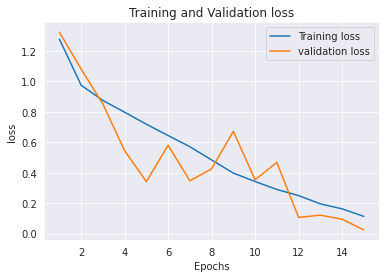

In [41]:
plt_acc_loss(loss_stats['train'], loss_stats['validation'], epochs, 'loss')

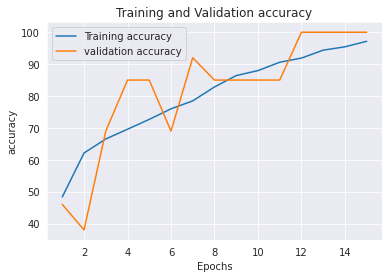

In [42]:
plt_acc_loss(accuracy_stats['train'], accuracy_stats['validation'], epochs, 'accuracy')

## Testing the CNN model

### Image transformation and y_true definition

In [43]:
image_transforms_tst = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_set = datasets.ImageFolder(root=tst_dir,
                                    transform=image_transforms_tst)

### Testing

In [44]:
test_loader = DataLoader(dataset=test_set, shuffle=True, batch_size=1, num_workers=workers)

y_pred_list = []
y_true_list = []

TGREEN = '\033[1;37;42m'
TRED = '\033[1;37;41m'
TBLUE = '\033[1;34;40m'

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x, y = x.to(gpu), y.to(gpu)

        # img_x = utils.make_grid(x)
        # plt.imshow(img_x.permute(1, 2, 0) + 0.3)
        # plt.show()

        y_test_pred = cnn_model(x)
        _, y_pred = torch.max(y_test_pred, dim=1)

        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y.cpu().numpy())
        # if y_pred == 0:
        #     print(TGREEN + "The person is wearing n95 mask with valve. \n")
        # elif y_pred == 1:
        #     print(TRED + "The person is not wearing a mask.\n")
        # else:
        #     print(TBLUE + "The person is wearing a surgical mask.\n")
        # print('\n')
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

  0%|          | 0/330 [00:00<?, ?it/s]

### Comparing test results

In [45]:
print('______________________ /CLASSIFICATION REPORTS\ _______________________\n')
print(classification_report(y_true_list, y_pred_list))
print('\n_________________________ /CONFUSION MATRIX\ __________________________\n')
print(confusion_matrix(y_true_list, y_pred_list))
print('\n_________________________ /MEAN SQUARED ERROR\ __________________________\n')
print(f'{mean_squared_error(y_true_list, y_pred_list):.3f}')

______________________ /CLASSIFICATION REPORTS\ _______________________

              precision    recall  f1-score   support

           0       0.67      0.78      0.72        78
           1       0.72      0.62      0.67        50
           2       0.65      0.71      0.68        49
           3       0.84      0.88      0.86        78
           4       0.82      0.65      0.73        75

    accuracy                           0.74       330
   macro avg       0.74      0.73      0.73       330
weighted avg       0.75      0.74      0.74       330


_________________________ /CONFUSION MATRIX\ __________________________

[[61  3  4  7  3]
 [ 7 31  5  3  4]
 [ 6  2 35  3  3]
 [ 2  3  3 69  1]
 [15  4  7  0 49]]

_________________________ /MEAN SQUARED ERROR\ __________________________

1.724


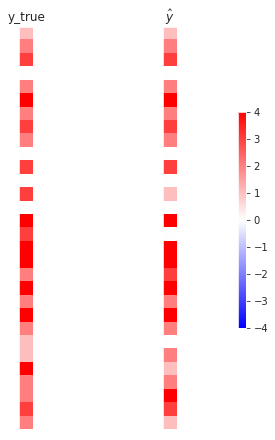

In [46]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list[: 30]),
    '$\hat{y}$': torch.FloatTensor(y_pred_list[: 30])
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))